# Preliminary Analysis
In this notebook, we will validate the behavior of all functions to ensure they work as expected. We will also verify what can be simplified or neglected during the dimensioning process (handled in a separate notebook).

In [121]:
# 3rd Party Libraries
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import math
from IPython.display import display, Math

# Internal Libraries
import functions as f
import nuclei_func as nf
from functions import Material_Proprieties, ThermoHydraulicSpecs, GeometryData, DimensioningData, Temperature_Map

## Input Data

All material proprietes (Fuel, Helium, Cladding and Coolant) are saved in a custom defined class to avoid repeatedly passing many parameters to functions, reducing complexity and improving code readability and maintainability.

In [122]:
# Material: Cladding
# 15-15, Ti stabilized, cold worked stainless steel
Cladding_Proprieties = Material_Proprieties(
    Elements=["Cr", "Ni", "Mo", "Mn", "Si", "Ti", "C", "B [ppm]"],
    Qualities=[15, 15, 1.5, 1.5, 0.9, 0.4, 0.09, 60],
    Density=lambda eth: 7900 * (1 + eth)**-3,  # kg/m^3
    Thermal_Conductivity=lambda t: 13.95 + 0.01163 * t,  # W/m K
    Emissivity = 0.32, # -
    Thermal_Expansion_Coeff=lambda t: -3.101e-4 + 1.545e-5 * t + 2.75e-9 * t**2,  # 1/°C
    Specific_Heat=500,  # Approximate value in J/kg K for steel
    Melting_Temperature=1673,  # K
    
    Youngs_Modulus=lambda t: 202.7 - 0.08167 * t,  # GPa
    Poissons_Ratio=lambda t: 0.277 + 6e-5 * t,  # Dimensionless
    Yield_Stress=lambda t: 555.5 - 0.25 * t if t < 600 else (405.5 - 0.775 * (t - 600) if t < 1000 else 345.5 - 0.25 * t),  # MPa
    Ultimate_Tensile_Strength=lambda t: 700 - 0.3125 * t if t < 600 else (512.5 - 0.969 * (t - 600) if t < 1000 else 437.5 - 0.3125 * t),  # MPa
)

# Material: Fuel
# Homogeneous MOX fuel

# Qualities have to be converted from weight to molar (won't change in hot condition):
mol_qual = nf.w2mol([0.711, 0.29], [235 + 2*16, 239 + 2*16])  # UO2, PuO2

Fuel_Proprieties = Material_Proprieties(
    Elements=["U-235", "U-238", "O-16", "Pu"],
    Qualities=[mol_qual[0] * (1 - mol_qual[1]), (1 - mol_qual[0]) * (1 - mol_qual[1]), 2, mol_qual[1]], # Molar fractions
    Theoretical_Density=11.31, # g/cm^3
    Percent_of_Theoretical_Density = 94.5, # %
    Molar_Mass=[235.0439299, 238.05078826, 15.99491461956, 244.064204],  # g/mol
    Thermal_Conductivity=lambda k_inf, beta: 1.755 + (k_inf - 1.755) * math.exp(-beta),  # W/m K
    Emissivity = 0.79, # -
    Thermal_Expansion_Coeff=1.2e-5,  # 1/°C
    Specific_Heat=270,  # Approximate value in J/kg K for MOX fuel
    Melting_Temperature=lambda pu, x, beta: 2964.92 + ((3147 - 364.85 * pu - 1014.15 * x) - 2964.92) * math.exp(-beta/41.01),  # K
    Oxigen_to_metal_ratio = 1.957, # -
    Grain_diameter = 10 * 1e-6,  # m
    Youngs_Modulus=lambda t, p: (22.43 * 10**4 - 31.19 * t) * (1 - 2.6 * p),  # MPa
    Poissons_Ratio=0.32,  # Dimensionless
)

# Material: Coolant (Sodium)
Coolant_Proprieties = Material_Proprieties(
    Elements=["Na"],
    Qualities=[1],
    Density=lambda t: 954.1579 + ((t-273) * 9/5 +32) *( ((t-273) * 9/5 +32) * ((((t-273) * 9/5 +32) * 0.9667e-9 - 0.46e-5)) - 0.1273534),  # kg/m^3 (t * 9/5 +32) is the convertion from C to K to F
    Viscosity=lambda t: (math.exp(813.9 / t -2.530 ))/1000,  # Pa s
    Thermal_Conductivity=lambda t: 110 - 0.0648 * t + 1.16e-5 * t**2,  # W/m K
    Specific_Heat=lambda t: 1608 - 0.7481 * t + 3.929e-4 * t**2,  # J/kg K
    
    Melting_Temperature=98,  # °C
    Boiling_Temperature=882,  # °C
    Nusselt_Number=lambda pe: 7 + 0.025 * pe**0.8
)

# Material: Helium (Filling Gas)
Helium_Proprieties = Material_Proprieties(
    Elements=["He"],
    Qualities=[1],
    Density=0.1786,  # kg/m^3 at STP
    Thermal_Conductivity=lambda t: 15.8e-4 * t**0.79,  # W/m K
    Specific_Heat=5193,  # J/kg K at constant pressure
    Thermal_Expansion_Coeff=3.66e-3  # Approximate value for helium in 1/°C
)


Other data is saved as common variables

In [123]:
Geometrical_Data = GeometryData(
    fuel_outer_diameter=5.42 * 1e-3,  # m - GIVEN
    fuel_inner_diameter=0.00 * 1e-3,  # m
    cladding_outer_diameter=6.55 * 1e-3,  # m - GIVEN
    thickness_cladding=0.3 * 1e-3, # m
    pin_pitch=8.275 * 1e-3,  # m
    h_values = np.linspace(0, 0.85, 1000), # m
    fuel_pellet_height = 7e-3, # m
    fuel_roughness = 2e-6, # m
    cladding_roughness = 1e-6 # m
)

# Example of initializing Thermo-Hydraulic specifications
heights_of_slice_centre = [42.5, 127.5, 212.5, 297.5, 382.5, 467.5, 552.5, 637.5, 722.5, 807.5] # mm
ThermoHydraulics = ThermoHydraulicSpecs(
    coolant_inlet_temp=395 + 273,  # K
    coolant_inlet_pressure=1e5,  # Pa
    coolant_mass_flow_rate=0.049,  # kg/s
    q_linear_avg = 38.7e3,  #W/m,
    uptime = 360 * 24 * 3600,  # s
    h_peak_factor = [h * 1e-3 for h in heights_of_slice_centre],  # m
    peak_factors = [0.572, 0.737, 0.868, 0.958, 1, 0.983, 0.912, 0.802, 0.658, 0.498],
    neutron_flux_peak = 6.1e15  # Neutron Flux (> 100 keV) (10^15 n cm^-2 s^-1) at Peak Power Node    
)

vars = DimensioningData(
    filling_gas_pressure = 1e5,  # Pa
    filling_gas_temperature = 20,  # °C
    temperature_map = ''
)

# Data for Axial Nodalization of the Fuel Pin



Verification parameters that will be needed for dimensioning

In [124]:
# Data for Indicative Design Limits
max_fuel_temp = 2600  # °C
max_cladding_temp = 650  # °C
max_plenum_pressure = 5  # MPa
max_cladding_plastic_strain = 0.5  # %
max_cladding_swelling = 3  # %
max_coolant_velocity = 8  # m/s

## Thermal - Hydraulics Analysis

In [125]:
Computing_Temperature = ThermoHydraulics.coolant_inlet_temp  # K
display(Math(r'T_{\text{Computing}} = %s \, \text{K}' % Computing_Temperature))

<IPython.core.display.Math object>

In [126]:
#Preliminary check of coolant properties

density = Coolant_Proprieties.Density(Computing_Temperature)
viscosity = Coolant_Proprieties.Viscosity(Computing_Temperature)
thermal_conductivity = Coolant_Proprieties.Thermal_Conductivity(Computing_Temperature)
c_p = Coolant_Proprieties.Specific_Heat(Computing_Temperature)

display(Math(r'\rho_{coolant} =' + f'{density:.2f}' + r'\text{ kg/m}^3' ))
display(Math(r'\mu_{coolant} =' + f'{viscosity*1000:.2f}' + r'\text{ mPa s}' ))
display(Math(r'k_{coolant} =' + f'{thermal_conductivity:.2f}' + r'\text{ W/m K}' ))
display(Math(r'c_p =' + f'{c_p:.2f}' + r'\text{ J/kg K}' ))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [127]:
# Velocity and Passage Area Calculation
# To be modified with a proper evaluation

velocity, passage_area, d_h = f.hydraulic_flow(ThermoHydraulics, Geometrical_Data, Coolant_Proprieties, Computing_Temperature)

display(Math(r'v_{coolant} =' + f'{velocity:.2f}' + r'\text{ m/s}' ))
display(Math(r'A_{passage} =' + f'{passage_area*1e6:.2f}' + r'\text{ mm}^2' ))
display(Math(r'D_{hydr} =' + f'{d_h*1e3:.2f}' + r'\text{ mm}'))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [128]:
# Computing the Heat Transfer Coefficient between the Coolant and the cladding
temps = [Computing_Temperature]
htc_coolant, velocity = f.heat_trans_coefficient(Geometrical_Data, ThermoHydraulics, Coolant_Proprieties, temps)
htc_coolant = htc_coolant[0]
velocity = velocity[0]
# Display the heat transfer coefficient
display(Math(r'\alpha_{cladding - coolant} =' + f'{htc_coolant*1e-3:.2f}' + r'\text{ kW/m}^2\text{K}'))
display(Math(r'v =' + f'{velocity:.2f}' + r'\text{ m/s}'))
# display(Math(r'Pe =' + f'{peclet:.2f}' ))
# display(Math(r'Pr =' + f'{prandtl:.4f}' ))
# display(Math(r'D_{h} =' + f'{d_h*1e3:.2f}' + r'\text{ mm}' ))
# display(Math(r'Nu =' + f'{nusselt:.2f}' ))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Axial Power Profile

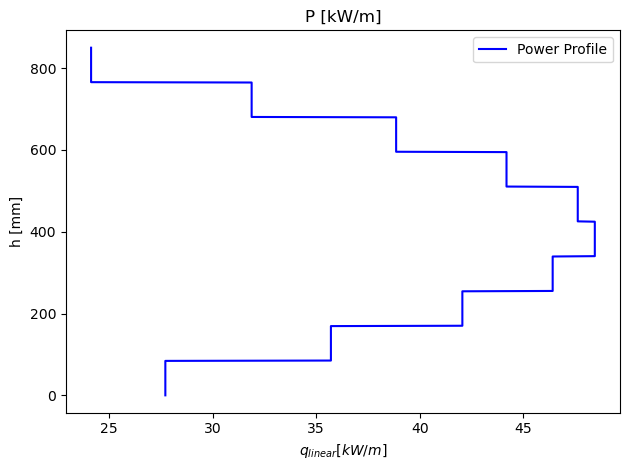

In [129]:
q_values = [f.power_profile(h, ThermoHydraulics) for h in Geometrical_Data.h_values]

# Create a figure with one subplot
fig, (power1) = plt.subplots(1)

# Plot the power profile
power1.plot(np.array(q_values)*1e-3, np.array(Geometrical_Data.h_values)*1e3, label='Power Profile', color='blue')

# Set title and axis labels
power1.set_title(r'P [kW/m]')
power1.set_xlabel(r'$q_{linear} [kW/m]$')
power1.set_ylabel(r'h [mm]')

# Add legend to the plot
power1.legend()

# Adjusts spacing between the plots
plt.tight_layout()

# Show the figure
plt.show()

### Radial temperature profile
Thermal resistances  
Fuel - Helium (gap) - Cladding - Coolant

In [130]:
R_coolant = f.thermal_resistance_coolant(Geometrical_Data, htc_coolant)
display(Math(r'R_{coolant} =' + f'{R_coolant:.6f}' + r'\frac{m \cdot K}{W}'))

<IPython.core.display.Math object>

In [131]:
R_cladding = f.thermal_resistance_cladding(Geometrical_Data, Cladding_Proprieties, Computing_Temperature)
display(Math(r'R_{cladding} =' + f'{R_cladding:.6f}' + r'\frac{m \cdot K}{W}'))

<IPython.core.display.Math object>

In [132]:
R_gap = f.thermal_resistance_gap(
    Geometrical_Data, Helium_Proprieties, Fuel_Proprieties, Cladding_Proprieties)

# Just to print a value
Temperature_Fuel_Out = Computing_Temperature # K
Temperature_Cladding_In = Computing_Temperature
Temperature_Gas = (Temperature_Fuel_Out + Temperature_Cladding_In) / 2
R_gap_eval = R_gap(Temperature_Gas, Temperature_Fuel_Out)
display(Math(r'R_{gap} =' + f'{R_gap_eval:.6f}' + r'\frac{m \cdot K}{W}'))

<IPython.core.display.Math object>

In [133]:
Temperature_Fuel = Computing_Temperature
Burnup = 0

R_fuel = f.thermal_resistance_fuel(Burnup, Fuel_Proprieties) # Outputs a lambda function
R_fuel_eval = R_fuel(Temperature_Fuel) # Evaluate the lambda function for display
display(Math(r'R_{fuel} =' + f'{R_fuel_eval:.6f}' + r'\frac{m \cdot K}{W}'))

<IPython.core.display.Math object>

In [134]:
class th_resistances:
    def __init__(self, R_fuel, R_gap, R_cladding, R_coolant):
        self.Fuel = R_fuel
        self.Gap = R_gap
        self.Cladding = R_cladding
        self.Coolant = R_coolant

Resistances = th_resistances(R_fuel, R_gap, R_cladding, R_coolant)

### Temperature Profile


3D plot computes all the points

In [135]:
# Pre-compute the temperature matrix using the plot function
r_coolant_infinity = Geometrical_Data.cladding_outer_diameter / 2 + Geometrical_Data.pin_pitch / np.sqrt(3)
r_coolant_cladding = Geometrical_Data.cladding_outer_diameter / 2
r_cladding_gap = Geometrical_Data.cladding_outer_diameter / 2 - Geometrical_Data.thickness_cladding
r_gap_fuel = Geometrical_Data.fuel_outer_diameter / 2
r_end = Geometrical_Data.fuel_inner_diameter / 2

r_coolant = np.linspace(r_coolant_infinity, r_coolant_cladding, 2)[0:-1]
r_cladding = np.linspace(r_coolant_cladding, r_cladding_gap, 2)[0:-1]
r_gap = np.linspace(r_cladding_gap, r_gap_fuel,5)[0:-1]
r_fuel = np.linspace(r_gap_fuel, r_end, 25)

r_plot = np.concatenate((r_coolant, r_cladding, r_gap, r_fuel))

# 3D plot of the temperature profile
T_fuel_out = 1500 # K (Initial guess)
vars.T_map = f.temperature_profile_3D(r_plot, Resistances, Coolant_Proprieties, ThermoHydraulics, Geometrical_Data, T_fuel_out, Burnup)

# Create a 3D surface plot
fig = go.Figure(data=[go.Surface(z=vars.T_map.T, x=vars.T_map.r*1e3, y=vars.T_map.h*1e3, colorscale='Viridis')])

# Update the layout
fig.update_layout(
    scene=dict(
        xaxis_title='Radius (mm)',
        yaxis_title='Height (mm)',
        zaxis_title='Temperature (K)'
    ),
    title="3D Temperature Profile vs. Radius and Height (q_values)",
    autosize=False,
    width=800,
    height=800
)

# Show the plot
fig.show()
    

We can get the temperature value at any point

In [136]:
# Get temperature at a specific point (height and radius) using pre-computed data
height = 0e-3 # mm
radius = 8e-3 # mm
temperature_at_point = f.get_temperature_at_point(height, radius, vars.T_map)
print(f"Temperature at height {height*1e3} mm and radius {radius*1e3} mm: {temperature_at_point:.2f} K")

Temperature at height 0.0 mm and radius 8.0 mm: 668.19 K


We can plot the radial temperature profile

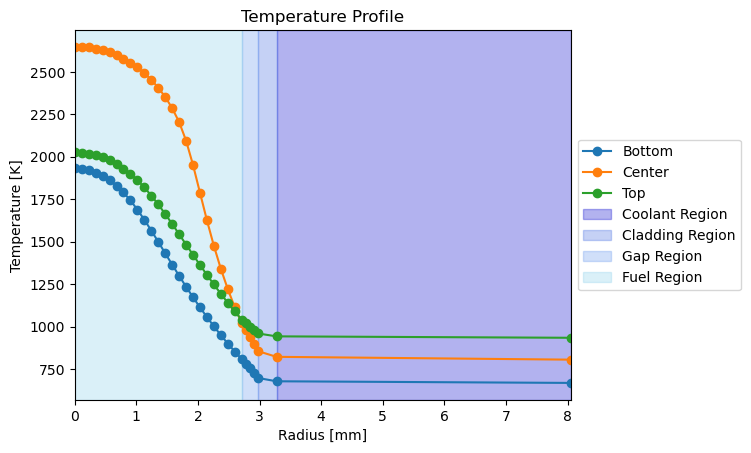

In [137]:
# 2D plot of the temperature profile
temp_plot_bottom = [f.get_temperature_at_point(0, r, vars.T_map) for r in r_plot]
temp_plot_center = [f.get_temperature_at_point(0.425, r, vars.T_map) for r in r_plot]
temp_plot_top = [f.get_temperature_at_point(0.850, r, vars.T_map) for r in r_plot]

# Create plot
plt.plot(r_plot * 1e3, temp_plot_bottom, label='Bottom', marker='o')
plt.plot(r_plot * 1e3, temp_plot_center, label='Center', marker='o')
plt.plot(r_plot * 1e3, temp_plot_top, label='Top', marker='o')

r_0 = Geometrical_Data.fuel_inner_diameter/2 * 1e3
r_1 = Geometrical_Data.fuel_outer_diameter/2 * 1e3
r_2 = Geometrical_Data.cladding_outer_diameter/2 * 1e3 - Geometrical_Data.thickness_cladding * 1e3
r_3 = Geometrical_Data.cladding_outer_diameter/2 * 1e3 
r_4 = r_plot[0]*1e3

# Add shading to different regions
colors = ['#00008B', '#0000CD', '#4169E1', '#6495ED', '#87CEEB']
plt.axvspan(r_3, r_4, color=colors[1], alpha=0.3, label='Coolant Region')
plt.axvspan(r_2, r_3, color=colors[2], alpha=0.3, label='Cladding Region')
plt.axvspan(r_1, r_2, color=colors[3], alpha=0.3, label='Gap Region')
plt.axvspan(r_0, r_1, color=colors[4], alpha=0.3, label='Fuel Region')

# Set title and axis labels
plt.title('Temperature Profile')
plt.xlabel('Radius [mm]')
plt.xlim(r_0, r_4)
plt.ylabel('Temperature [K]')

# Add legend to the plot
plt.legend()

# Put the legend out of the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the figure
plt.show()

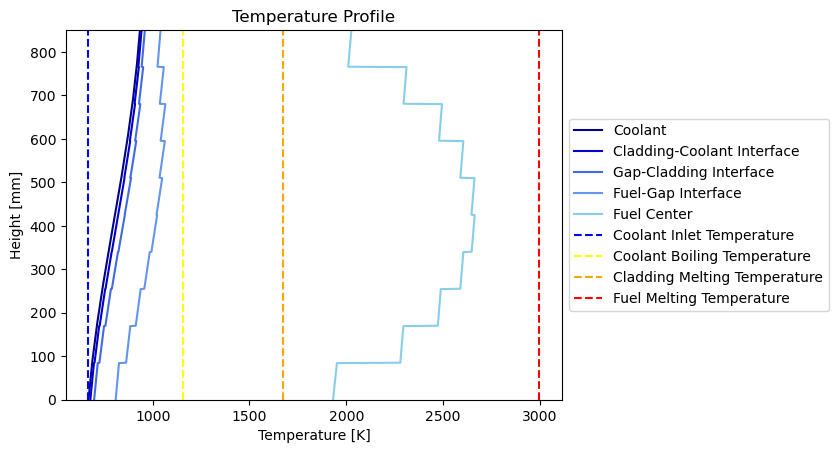

In [138]:
# 2D plot of the temperature profiles along the axial direction
r_to_plot = [vars.T_map.r[-1],
             Geometrical_Data.cladding_outer_diameter/2,
             Geometrical_Data.cladding_outer_diameter / 2 - Geometrical_Data.thickness_cladding,
             Geometrical_Data.fuel_outer_diameter/2,
             Geometrical_Data.fuel_inner_diameter/2]

labels = ['Coolant', 
          'Cladding-Coolant Interface', 
          'Gap-Cladding Interface', 
          'Fuel-Gap Interface', 
          'Fuel Center']

colors = ['#00008B', '#0000CD', '#4169E1', '#6495ED', '#87CEEB']
h_vals = Geometrical_Data.h_values

to_plot = 5
for i in range(to_plot):
    temp_axial = [f.get_temperature_at_point(h, r_to_plot[i], vars.T_map) for h in h_vals]
    plt.plot(temp_axial, h_vals*1e3, label=labels[i], color=colors[i])

# Plot a line at the coolant inlet temperature
plt.axvline(x=ThermoHydraulics.coolant_inlet_temp, color='b', linestyle='--', label='Coolant Inlet Temperature')

# Plot a line at the coolant boling temperature
plt.axvline(x=Coolant_Proprieties.Boiling_Temperature + 273, color='yellow', linestyle='--', label='Coolant Boiling Temperature')

# Plot a line at the cladding melting temperature
plt.axvline(x=Cladding_Proprieties.Melting_Temperature, color='orange', linestyle='--', label='Cladding Melting Temperature')

# Plot a line at the fuel melting temperature
stechiometry = 2 - Fuel_Proprieties.Oxigen_to_metal_ratio
pu_weight = 0.29
plt.axvline(x=Fuel_Proprieties.Melting_Temperature(pu_weight,stechiometry,Burnup), color='r', linestyle='--', label='Fuel Melting Temperature')

# Set title and axis labels
plt.title('Temperature Profile')
plt.ylabel('Height [mm]')
plt.ylim(0, 850)
plt.xlabel('Temperature [K]')

# Put the legend outside the plot
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the figure
plt.show()

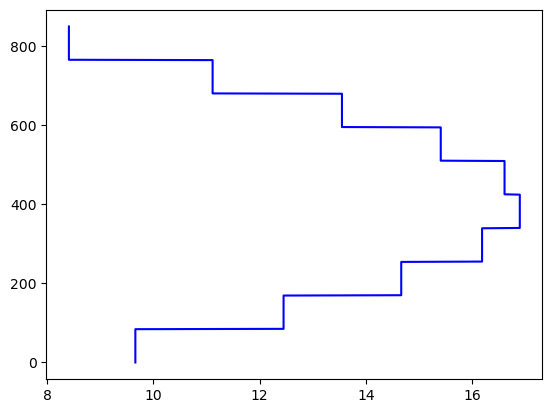

In [139]:
# plot the difference between the coolant profile and the cladding profile
temp_coolant = [-f.get_temperature_at_point(h, r_to_plot[0], vars.T_map) + f.get_temperature_at_point(h, r_to_plot[1], vars.T_map) for h in h_vals]

plt.plot(temp_coolant, h_vals*1e3, label='Coolant', color='blue')
plt.show()

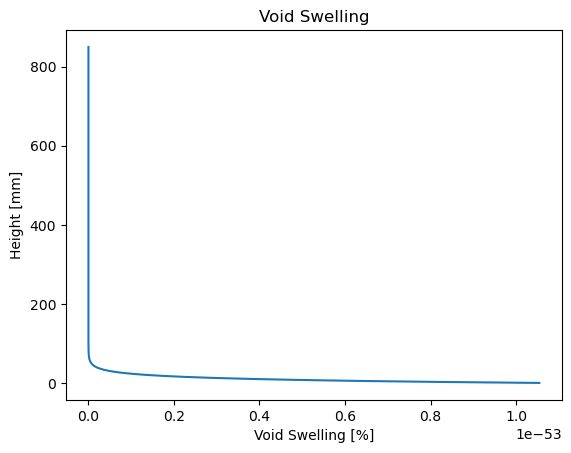

In [140]:
void_swell = f.void_swelling(vars.T_map, Geometrical_Data, ThermoHydraulics)

# Create plot
plt.plot(np.array(void_swell)*100, vars.T_map.h[:,0]*1000, label='Void Swelling')
plt.title('Void Swelling')
plt.xlabel('Void Swelling [%]')
plt.ylabel('Height [mm]')
plt.show()

##### Linee guida da chatGPT:  

Verification
Margin to Melting of the Fuel
Code to verify that the fuel temperature remains below the limit.

Temperature of the Cladding
Code for cladding temperature calculations.

Yielding of the Cladding
Code to determine the safety against yielding based on stress analysis.

Time to Rupture for Thermal Creep of the Cladding
Calculation and analysis of thermal creep failure time.

Considerations for Double Irradiation Time
Identify critical aspects to be considered if the irradiation time is doubled.

Results Visualization
Create plots where necessary, for example:
- Temperature profiles
- Creep stress against time